In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

In [2]:
# check submission format for Round 1 
sample_pred = pd.read_csv('data/MSampleSubmissionStage1_2020.csv')
display(sample_pred.head())
print(len(sample_pred))

,ID,Pred
0,2015_1107_1112,0.5
1,2015_1107_1116,0.5
2,2015_1107_1124,0.5
3,2015_1107_1125,0.5
4,2015_1107_1129,0.5


11390


# Import Data

In [3]:
tourney_results = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_results.info()
tourney_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 8 columns):
Season     2251 non-null int64
DayNum     2251 non-null int64
WTeamID    2251 non-null int64
WScore     2251 non-null int64
LTeamID    2251 non-null int64
LScore     2251 non-null int64
WLoc       2251 non-null object
NumOT      2251 non-null int64
dtypes: int64(7), object(1)
memory usage: 140.8+ KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [4]:
teams = pd.read_csv('data/MDataFiles_Stage1/MTeams.csv')
teams.info()
teams[teams['TeamName'].str.contains('Duke|North Carolina')]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
TeamID           367 non-null int64
TeamName         367 non-null object
FirstD1Season    367 non-null int64
LastD1Season     367 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.5+ KB


,TeamID,TeamName,FirstD1Season,LastD1Season
80,1181,Duke,1985,2020
213,1314,North Carolina,1985,2020


In [5]:
regular_results = pd.read_csv('data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
regular_results.info()
regular_results.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161552 entries, 0 to 161551
Data columns (total 8 columns):
Season     161552 non-null int64
DayNum     161552 non-null int64
WTeamID    161552 non-null int64
WScore     161552 non-null int64
LTeamID    161552 non-null int64
LScore     161552 non-null int64
WLoc       161552 non-null object
NumOT      161552 non-null int64
dtypes: int64(7), object(1)
memory usage: 9.9+ MB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [6]:
seeds = pd.read_csv('data/MDataFiles_Stage1/MNCAATourneySeeds.csv')
seeds.info()
seeds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286 entries, 0 to 2285
Data columns (total 3 columns):
Season    2286 non-null int64
Seed      2286 non-null object
TeamID    2286 non-null int64
dtypes: int64(2), object(1)
memory usage: 53.7+ KB


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


# Helper Functions

In [7]:
def clf_eda_numeric(data, feature, target='Won'):
    """ Creates EDA plots for a binary target vs. a select numeric feature """
    
    # set up axes and define attributes 
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
    neutral_color = list(plt.rcParams['axes.prop_cycle'])[3]['color']
    
    # top-left: boxplot 
    sns.boxplot(x=target, y=feature, data=data, ax=axes[0,0]) 
    
    # top-right: overlapping density plots, 1 for each class  
    for y in [0,1]:
        subset = data[data[target]==y]
        sns.distplot(subset[feature], label=y, ax=axes[0,1])
        xmin, xmax = data[feature].min(), data[feature].max()
        axes[0,1].set_xlim(xmin, xmax)
        axes[0,1].set_ylabel('Density')
        axes[0,1].legend()
        
    # bottom-left: line plot of average target by feature value  
    sns.lineplot(x=feature, y=target, color=neutral_color, data=data, ax=axes[1,0])
    
    # bottom-right: histogram of combined data 
    sns.distplot(data[feature], kde=False, norm_hist=True, label='Density', color=neutral_color, ax=axes[1,1])

# Construct Dataset + EDA

### Create IDs and Labels

Each observation in our dataset is a March Madness match-up between two teams in a particular season, uniquely identified by a SSSS_XXXX_YYYY ID, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team. The label of this observation is the outcome of the game, indicating whether the lower-ID team wins (1) or loses (0). 

In [8]:
def reformat_obs(tourney_results):
    """ Given tourney results, reformat and append dataframe with unique ID and label """
    
    data = tourney_results.assign(
        TeamA = lambda x: x[['WTeamID','LTeamID']].min(axis=1), 
        TeamB = lambda x: x[['WTeamID','LTeamID']].max(axis=1), 
        Teams = lambda x: x['TeamA'].astype(str) + '_' + x['TeamB'].astype(str),
        ID = lambda x: x['Season'].astype(str) + '_' + x['Teams'],
        Won = lambda x: np.where(x['WTeamID'] < x['LTeamID'], 1, 0),
        ScoreTeamA = lambda x: np.where(x['WTeamID'] == x['TeamA'], x['WScore'], x['LScore']),
        ScoreTeamB = lambda x: np.where(x['WTeamID'] == x['TeamB'], x['WScore'], x['LScore']),
        ScoreDiff = lambda x: x['ScoreTeamA'] - x['ScoreTeamB']
    )
    
    cols_to_return = ['ID', 'Season', 'TeamA', 'TeamB', 'Teams', 'Won', 
                      'ScoreTeamA', 'ScoreTeamB', 'ScoreDiff', 'DayNum', 'NumOT', 'WLoc']
    
    return data[cols_to_return] 

In [9]:
data = reformat_obs(tourney_results)
data.info()
display(data.sample(5))
data['Won'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 12 columns):
ID            2251 non-null object
Season        2251 non-null int64
TeamA         2251 non-null int64
TeamB         2251 non-null int64
Teams         2251 non-null object
Won           2251 non-null int64
ScoreTeamA    2251 non-null int64
ScoreTeamB    2251 non-null int64
ScoreDiff     2251 non-null int64
DayNum        2251 non-null int64
NumOT         2251 non-null int64
WLoc          2251 non-null object
dtypes: int64(9), object(3)
memory usage: 211.1+ KB


,ID,Season,TeamA,TeamB,Teams,Won,ScoreTeamA,ScoreTeamB,ScoreDiff,DayNum,NumOT,WLoc
1968,2015_1112_1462,2015,1112,1462,1112_1462,1,68,60,8,143,0,N
374,1990_1258_1424,1990,1258,1424,1258_1424,0,101,131,-30,146,0,N
1605,2010_1199_1211,2010,1199,1211,1199_1211,0,60,67,-7,137,0,N
286,1989_1123_1228,1989,1123,1228,1123_1228,0,60,72,-12,138,0,N
916,1999_1196_1451,1999,1196,1451,1196_1451,1,82,74,8,138,1,N


1    1137
0    1114
Name: Won, dtype: int64

### Create Seed Features

Here we append three features to our dataset: seedings of the respective teams for that season (`SeedA` for the lower-ID team and `SeedB` for the higher-ID team) and the difference between the two (`SeedDiff`=SeedB-SeedA). We expect the latter to be one of the most predictive features of the game outcome. 

In [10]:
def append_seed_features(data, seeds):
    """ Create seed features and append to main dataframe """
    seeds = seeds.copy() 
    seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds = seeds.set_index(['Season', 'TeamID'])
    df = data.merge(seeds, how='left', left_on=['Season', 'TeamA'], right_index=True)\
             .merge(seeds, how='left', left_on=['Season', 'TeamB'], right_index=True, suffixes=('A', 'B'))
    df['SeedDiff'] = df['SeedB'] - df['SeedA'] 
    return df 

In [11]:
data = append_seed_features(data, seeds)
data.head()

,ID,Season,TeamA,TeamB,Teams,Won,ScoreTeamA,ScoreTeamB,ScoreDiff,DayNum,NumOT,WLoc,SeedA,SeedB,SeedDiff
0,1985_1116_1234,1985,1116,1234,1116_1234,1,63,54,9,136,0,N,9,8,-1
1,1985_1120_1345,1985,1120,1345,1120_1345,1,59,58,1,136,0,N,11,6,-5
2,1985_1207_1250,1985,1207,1250,1207_1250,1,68,43,25,136,0,N,1,16,15
3,1985_1229_1425,1985,1229,1425,1229_1425,1,58,55,3,136,0,N,9,8,-1
4,1985_1242_1325,1985,1242,1325,1242_1325,1,49,38,11,136,0,N,3,14,11


Not surprisingly, the higher a team is seeded, the more likely it is to win. 

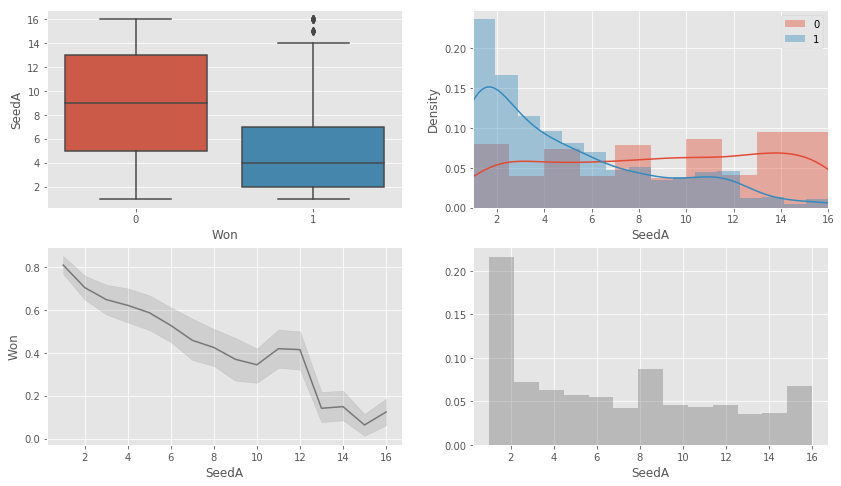

In [12]:
clf_eda_numeric(data, feature='SeedA')

Conversely, the higher a team's opponent is seeded, the less likely a team is to win. 

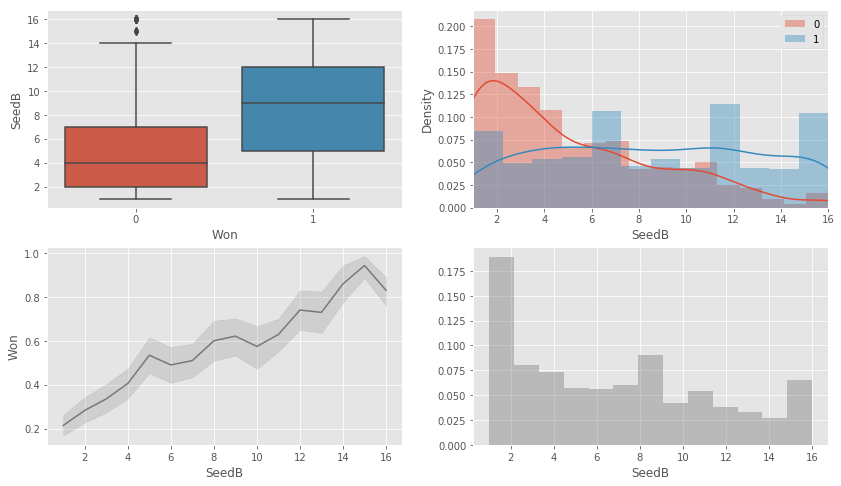

In [13]:
clf_eda_numeric(data, feature='SeedB')

Perhaps the relative seeding of the teams is the most telling: conventional wisdom assumes the higher-seeded team wins, and the greater the gap in seedings, the higher the probability of winning. Our EDA below appears mostly consistent with our intuition.

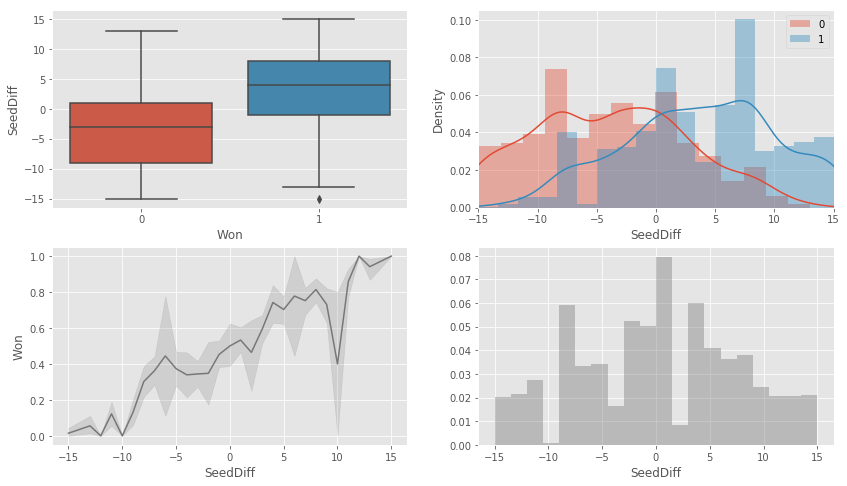

In [297]:
clf_eda_numeric(data, feature='SeedDiff')

### Create historical tourney head-to-head features 

In [ ]:
def append_hist_tourney_stats 

In [147]:
playoff_h2h = compact_results\
    .merge(compact_results, how='left', on='Teams', suffixes=('_1','_2'))\
    .query("Season_1 > Season_2")\
    .groupby(['Teams','Season_1'])\
    .agg({'Outcome_2': ['size', np.sum]})\
    .reset_index()
playoff_h2h.columns = ['Teams', 'Season', 'playoff_h2h_total', 'playoff_h2h_wins']
playoff_h2h['playoff_h2h_losses'] = playoff_h2h['playoff_h2h_total'] - playoff_h2h['playoff_h2h_wins']
playoff_h2h['playoff_h2h_net'] = playoff_h2h['playoff_h2h_wins'] - playoff_h2h['playoff_h2h_losses']
playoff_h2h.head()

,Teams,Season,playoff_h2h_total,playoff_h2h_wins,playoff_h2h_losses,playoff_h2h_net
0,1104_1112,1990,1,1,0,1
1,1104_1344,1994,1,0,1,-1
2,1104_1390,2004,1,1,0,1
3,1112_1181,2011,1,0,1,-1
4,1112_1211,2014,1,1,0,1


In [148]:
compact_results.query("Teams == '1181_1242'")[['Teams','Season','Outcome','WScore','LScore']]

,Teams,Season,Outcome,WScore,LScore
123,1181_1242,1986,1,71,67
249,1181_1242,1988,0,66,59
440,1181_1242,1991,1,72,65
985,1181_1242,2000,1,69,64
1186,1181_1242,2003,0,69,65
2179,1181_1242,2018,0,85,81


In [149]:
playoff_h2h.query("Teams == '1181_1242'")

,Teams,Season,playoff_h2h_total,playoff_h2h_wins,playoff_h2h_losses,playoff_h2h_net
74,1181_1242,1988,1,1,0,1
75,1181_1242,1991,2,1,1,0
76,1181_1242,2000,3,2,1,1
77,1181_1242,2003,4,3,1,2
78,1181_1242,2018,5,3,2,1


### Baseline Model (1): Logistic Regression w/ SeedDiff Only

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [151]:
df = compact_results.merge(seeds, how='left', left_on=['Season', 'TeamA'], right_index=True)\
                    .merge(seeds, how='left', left_on=['Season', 'TeamB'], right_index=True, suffixes=('_A', '_B'))
df['SeedDiff'] = df['SeedNum_B'] - df['SeedNum_A'] 

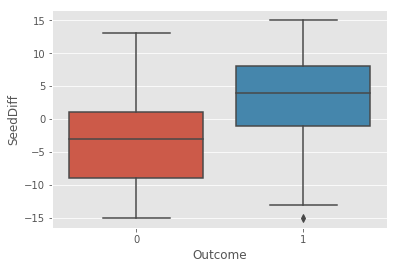

In [153]:
# train/test split: train on seasons through 2016, validate on seasons 2017-19 
train = df.query("Season < 2017")
val = df.query("Season >= 2017")
print("Train: {} | Val: {}".format(len(train), len(val)))

Train: 2050 | Val: 201


In [154]:
lr_seeddiff = LogisticRegression()
lr_seeddiff.fit(train[['SeedDiff']], train['Outcome'])
lr_preds = lr_seeddiff.predict_proba(val[['SeedDiff']])
log_loss(val['Outcome'], lr_preds)

0.5577789914274504

### Random Forest w/ Seed + Playoff H2H 

In [155]:
from sklearn.ensemble import RandomForestClassifier

In [163]:
RF_FEATURES = ['SeedDiff','playoff_h2h_net']

In [164]:
df1 = df.merge(playoff_h2h, how='left', on=['Season','Teams'])
df1[RF_FEATURES] = df1[RF_FEATURES].fillna(0)
train1 = df1.query("Season < 2017")
val1 = df1.query("Season >= 2017")
print("Train: {} | Val: {}".format(len(train1), len(val1)))

Train: 2050 | Val: 201


In [165]:
rf_seeds = RandomForestClassifier()
rf_seeds.fit(train1[RF_FEATURES], train1['Outcome'])
rf_seeds_preds = rf_seeds.predict_proba(val1[RF_FEATURES])
log_loss(val1['Outcome'], rf_seeds_preds)

0.8962318789251664